In [1]:
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [18, 8]

%connect_info

{
  "stdin_port": 52769,
  "key": "cca072ef-a2cbcb3436ece895296363b6",
  "control_port": 47944,
  "ip": "127.0.0.1",
  "transport": "tcp",
  "iopub_port": 32960,
  "hb_port": 41608,
  "shell_port": 43956,
  "kernel_name": "",
  "signature_scheme": "hmac-sha256"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-0c36b1e8-c42d-4a86-a8ae-1b2c93f43c6d.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# utils
from scipy.signal import periodogram
from contextlib import contextmanager

@contextmanager
def fig(*args, **kwargs):
    fig = plt.figure(*args, **kwargs)
    fig.set_size_inches([18, 8])
    yield fig
    plt.show()
    plt.close()
    
@contextmanager
def small_fig(*args, **kwargs):
    fig = plt.figure(*args, **kwargs)
    fig.set_size_inches([12, 6])
    yield fig
    plt.show()
    plt.close()

def get_artifacts(s, val):
    d = np.diff((s == val).astype(int))
    starts = np.where(d > 0)[0]
    stops = np.where(d < 0)[0]
    for start, stop in zip(starts, stops):
        yield start, stop

In [3]:
ls -R

.:
10.1109@iccas.2007.4406545.pdf  main.ipynb                 untitled.txt
data/                           mimikry_au_analysis.ipynb
Gaze Analysis.ipynb             Untitled.ipynb

./data:
BERT_c_dynamic.csv  bert_tracking_results_.csv  data.hdf5  gaze.hdf5


In [4]:
with pd.HDFStore('data/gaze.hdf5') as store:
    # load dataset
    data = store['data']


## compute spherical coordinates

the idea behind this is that the gaze vectory are actually vectors that are described by spherical coordinates with two angles phi and theta and length one, since the face tracker only estimates a direction and not a specific point of focus. This way it is possible to describe these vectors with only two dimensions instead of three.

In [5]:
def get_spherical_coordinates(cartesian):
    """
    take signal in cartesian coordinates with shape (n, 3) and return array with spherical coordinates
    r (radius), theta and phi
    """
    spherical = np.zeros(cartesian.shape)
    # r
    spherical[:, 0] = np.sqrt(cartesian[:, 0] ** 2 + cartesian[:, 1] ** 2 + cartesian[:, 2] ** 2)

    # theta
    spherical[:, 1] = np.arccos(cartesian[:, 0] / spherical[:, 0])
    # phi
    spherical[:, 2] = np.arctan2(cartesian[:, 1], cartesian[:, 0])
    
    return spherical

col_selection = np.array([i for i, x in enumerate(data.columns) if x.startswith('gaze')])

gaze_sphere1 = get_spherical_coordinates(data.values[:, col_selection[:3]].astype(np.float64))
# verify that the assumption of z == 1 is really true
print('maxiumum deviation from 1 in radius 1: ', np.abs(gaze_sphere1[:, 0] - 1).max()) # this is neglectable

gaze_sphere2 = get_spherical_coordinates(data.values[:, col_selection[3:]].astype(np.float64))
print('maxiumum deviation from 1 in radius 2: ',np.abs(gaze_sphere2[:, 0] - 1).max()) # this is neglectable

data.loc[:, 'gaze_0_theta'] = gaze_sphere1[:, 1]
data.loc[:, 'gaze_0_phi'] = gaze_sphere1[:, 2]

data.loc[:, 'gaze_1_theta'] = gaze_sphere2[:, 1]
data.loc[:, 'gaze_1_phi'] = gaze_sphere2[:, 2]

maxiumum deviation from 1 in radius 1:  7.38172727388e-07
maxiumum deviation from 1 in radius 2:  7.77544697739e-07


In [106]:
gaze0 = data.loc[:, ['gaze_0_x', 'gaze_0_y','gaze_0_z']]
gaze1 = data.loc[:, ['gaze_1_x', 'gaze_1_y','gaze_1_z']]

get_spherical_coordinates(gaze0.values + gaze1.values)


array([[ 1.98382978,  1.58034467,  1.78257418],
       [ 1.98692046,  1.56910325,  1.52135892],
       [ 1.98066492,  1.58359339,  1.82495749],
       ..., 
       [ 1.9843133 ,  1.53907308,  1.33619266],
       [ 1.98427401,  1.53949579,  1.34227704],
       [ 1.98384339,  1.54060922,  1.35054889]])

## filter out artifacts

The first idea of identifying Artifact regions aim at removing areas where the gaze signal stays absolutely constant, i.e. has first derivative == 0

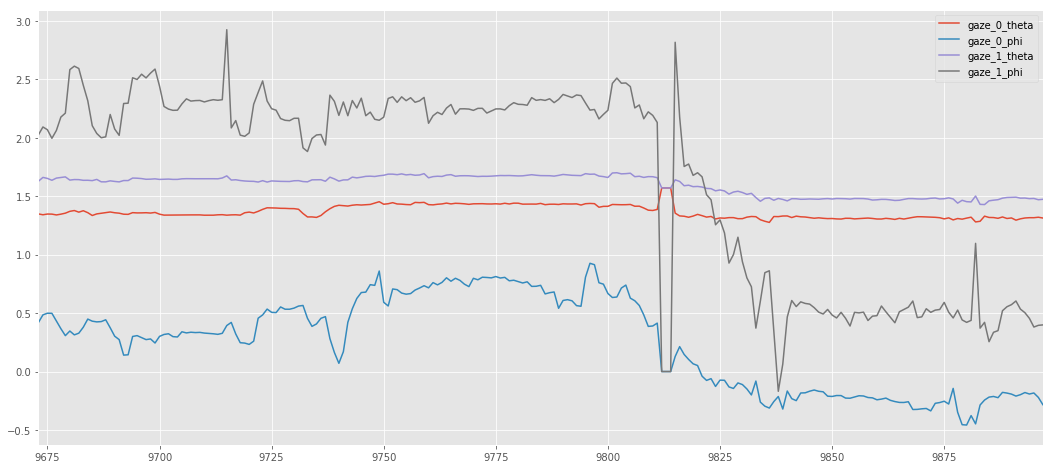

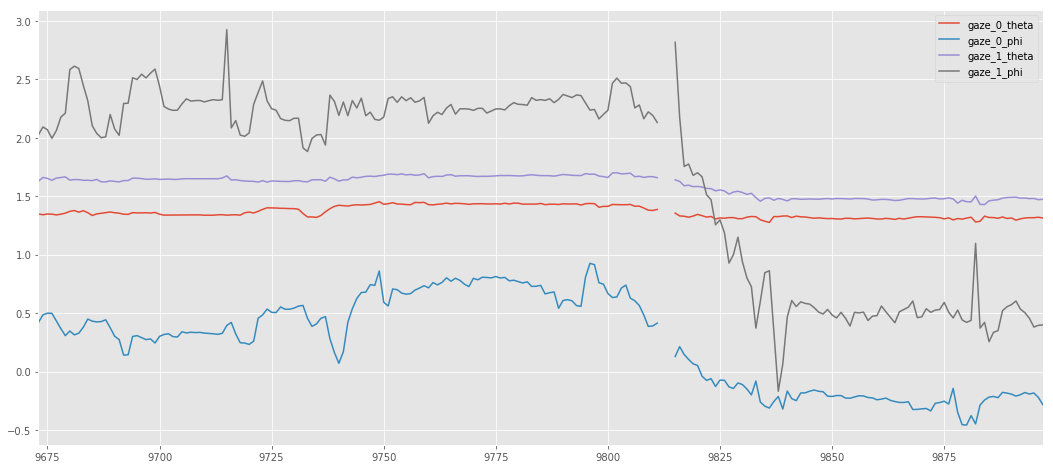

11119671


In [6]:
gaze_angle_cols = ['gaze_0_theta', 'gaze_0_phi', 'gaze_1_theta', 'gaze_1_phi']

# work on a copy to avoid premature changes to the original dataset
data_ = data.copy()

# compute areas where first derivative is 0
sel = (np.diff(data_.loc[:, gaze_angle_cols].values, axis=0) == 0).any(axis=1)
# include 1 point more
sel[np.where(sel)[0] + 1] = True

# plot example epoch containing artifacts
# before
(pic, s_id), epoch = next(iter(data.groupby(['pic', 's_id'])))
with fig():
    epoch.loc[:, gaze_angle_cols].plot(ax=plt.gca())

data_.loc[sel, gaze_angle_cols] = float('nan')

# and after masking artifacts
(pic, s_id), epoch = next(iter(data_.groupby(['pic', 's_id'])))
with fig():
    epoch.loc[:, gaze_angle_cols].plot(ax=plt.gca())

print(s_id)

since there is enough data in the dataset to deterine a stable distribution of angle changes, also regions with unusual changes should be excluded

In [7]:
# compute first derivative on all continuous time blocks (epochs)
diffs = []

for (pic, s_id), epoch in data.loc[~sel,:].groupby(['pic', 's_id']):
    diffs.append(np.diff(epoch.loc[:, gaze_angle_cols].values, axis=0))
    
diffs = pd.DataFrame(np.concatenate(diffs, axis=0), columns = gaze_angle_cols)


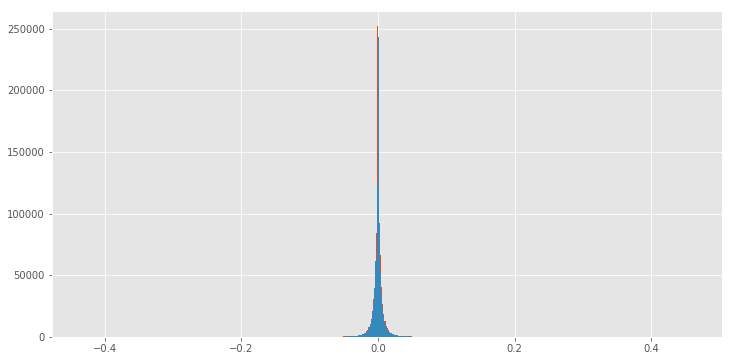

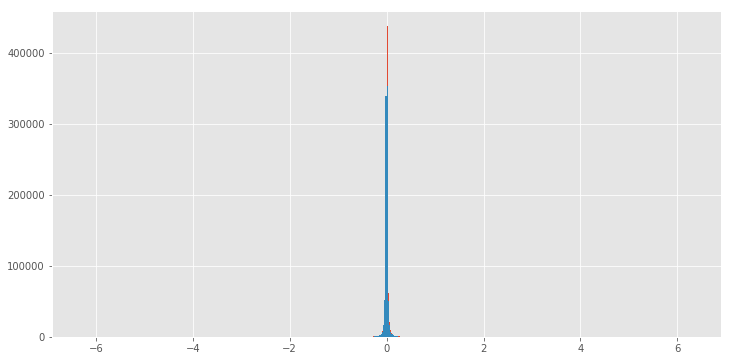

In [8]:
# plot the distributions of the first derivatives
# the idea is that too fast changes also are due to artifacts

with small_fig():
    diffs.loc[:, 'gaze_0_theta'].hist(ax=plt.gca(), bins=500)
    diffs.loc[:, 'gaze_1_theta'].hist(ax=plt.gca(), bins=500)
with small_fig():
    diffs.loc[:, 'gaze_0_phi'].hist(ax=plt.gca(), bins=500)
    diffs.loc[:, 'gaze_1_phi'].hist(ax=plt.gca(), bins=500)

In [9]:
# calculate thresholds
lower_threshold = diffs.mean() - 5 * diffs.std()
upper_threshold = diffs.mean() + 5 * diffs.std()

In [10]:
# now apply exlusions...

tbd = []

for (pic, s_id), epoch in data.groupby(['pic', 's_id']):
    d = epoch.loc[:, gaze_angle_cols].diff()
    
    lower = d < lower_threshold
    upper = d > upper_threshold
    
    zero = d == 0
    
    tbd.append(epoch.loc[lower.any(axis=1) | upper.any(axis=1) | zero.any(axis=1),:].index.values)

sel = np.concatenate(tbd, axis=0)
data.loc[sel, [x for x in data.columns if x.startswith('gaze')]] = float('nan')

In [11]:
# and save generated data frames
with pd.HDFStore('data/gaze.hdf5') as store:
    store['data_filtered'] = data

*Note that this way of just removing lines where the tracking failed, **generates discontinuous time series**, which has to be taken into account, if the specific time series character of the data is used (e.g. for fft-based techniques)*

# Estimate speed and acceleration of eye movements

Calculate first and second derivatives for each epoch and look at differences between groups.

In [12]:
epochs = pd.DataFrame()

speeds = []
# accelerations
accs = []

for i, ((pic, s_id), epoch) in enumerate(data.groupby(['pic', 's_id'])):
    values = epoch.loc[:, ['gaze_0_x', 'gaze_0_y', 'gaze_0_z']]

    speed = np.diff(values.values, axis=0)
    acc = np.diff(speed, axis=0)

    speed = np.linalg.norm(speed, axis=1)
    acc = np.linalg.norm(acc, axis=1)
    
    speeds.append(speed)
    accs.append(acc)

    epochs.loc[i, 'pic'] = pic
    epochs.loc[i, 's_id'] = s_id
    
speeds = pd.DataFrame(speeds)
accs = pd.DataFrame(accs)

speeds = pd.concat([speeds, epochs], axis=1)
accs = pd.concat([accs, epochs], axis=1)

In [13]:
# add neurotype information to data frames
speeds = speeds.merge(data.loc[:, ['s_id', 'neurotypes']].drop_duplicates())
accs = accs.merge(data.loc[:, ['s_id', 'neurotypes']].drop_duplicates())


In the following cells, all the epochs are joined into one data set for each group and a two-sided t-test is performed to show that they are significantly different.


In [14]:
from scipy.stats import ttest_ind

value_cols = speeds.columns[:-3]

pvals = []
asd_bigger = []

for pic, vals in speeds.groupby('pic'):
    nt = vals.loc[vals.neurotypes == 'nt', value_cols].values.flatten()
    asd = vals.loc[vals.neurotypes == 'asd', value_cols].values.flatten()
    
    asd_bigger.append(asd[~np.isnan(asd)].mean() > nt[~np.isnan(nt)].mean())
    
    res = ttest_ind(nt, asd, nan_policy='omit', equal_var=False)
    pvals.append(res.pvalue)
    
# bonferroni
alpha = 0.001 / len(pvals)

(np.array(pvals) < alpha) & asd_bigger

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True], dtype=bool)

In [20]:
pvals = []
asd_bigger = []

for pic, vals in accs.groupby('pic'):
    nt = vals.loc[vals.neurotypes == 'nt', value_cols].values.flatten()
    asd = vals.loc[vals.neurotypes == 'asd', value_cols].values.flatten()
    
    asd_bigger.append(asd[~np.isnan(asd)].mean() > nt[~np.isnan(nt)].mean())
    
    res = ttest_ind(nt, asd, nan_policy='omit', equal_var=False)
    pvals.append(res.pvalue)
    
# bonferroni
alpha = 0.001 / len(pvals)

np.array(pvals) < alpha

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True], dtype=bool)

now repeat with ks test for mean values over participants.

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


plot pvalues for each picture


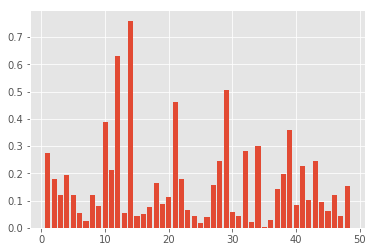

In [43]:
from scipy.stats import ks_2samp

from pprint import pprint

value_cols = speeds.columns[:-3]

pvals = []
asd_bigger = []

for pic, vals in speeds.groupby('pic'):
    nt = vals.loc[vals.neurotypes == 'nt', value_cols].mean(axis=1)
    asd = vals.loc[vals.neurotypes == 'asd', value_cols].mean(axis=1)
    
    #pd.concat([nt, asd], axis=1).hist(bins=20)
        
    stat, pval = ks_2samp(nt, asd)
    pvals.append(pval)    
    asd_bigger.append(asd[~np.isnan(asd)].mean() > nt[~np.isnan(nt)].mean())

# bonferroni
alpha = 0.001 / len(pvals)

print((np.array(pvals) < alpha) & asd_bigger)

print('\n\nplot pvalues for each picture')
plt.bar(range(1, len(pvals) + 1), pvals)
plt.show()

... and repeat again for means over each subject and all pictures

In [55]:
def test_all_means(values, column_selection):
    
    means = []

    for s_id, vals in values.groupby('s_id'):
        mean = vals.loc[:, column_selection].mean().mean()
        means.append((mean, vals.neurotypes.iloc[0]))

    means = pd.DataFrame(means, columns = ['mean', 'nt'])

    groups = list(means.groupby('nt'))

    asd = groups[0][1].loc[:, 'mean'].values
    nt = groups[1][1].loc[:, 'mean'].values
    
    print('---')
    print('nt group: ')
    print('mean: ', nt[~np.isnan(nt)].mean())
    print('stddev: ', nt[~np.isnan(nt)].std())
    
    print('---')
    print('asd group: ')
    print('mean: ', asd[~np.isnan(asd)].mean())
    print('stddev: ', asd[~np.isnan(asd)].std())
    
    stat, pval = ks_2samp(nt, asd)
    return pval

print('\n\n')
print('test speed values')
pval = test_all_means(speeds, speeds.columns[:-3])
print('====')
print('pvalue for speeds: ', pval)

print('\n\n')
print('test acc values')
pval = test_all_means(accs, accs.columns[:-3])
print('====')
print('pvalue for accelerations: ', pval)





test speed values
---
nt group: 
mean:  0.00582236560337
stddev:  0.002929441601
---
asd group: 
mean:  0.0075476053867
stddev:  0.00359785189626
====
pvalue for speeds:  0.0935758096014



test acc values
---
nt group: 
mean:  0.00895128863874
stddev:  0.00459455629575
---
asd group: 
mean:  0.0116219153155
stddev:  0.00561116068091
====
pvalue for accelerations:  0.152712691037


nt
asd    [[Axes(0.125,0.125;0.775x0.755)]]
nt     [[Axes(0.125,0.125;0.775x0.755)]]
dtype: object

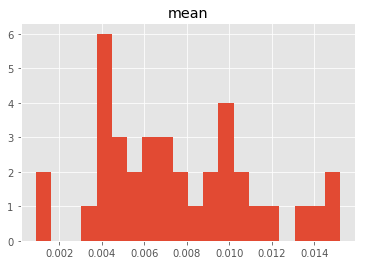

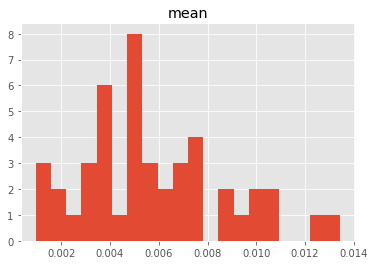

In [46]:
# plot mean distribtions

means.groupby('nt').hist(bins=20)

# Calculate kernel density estimates for gaze angle configurations

## Plot KDE for one picture

In [71]:
with pd.HDFStore('data/gaze.hdf5') as store:
    densities = store['densities']

show that only certain configurations appear

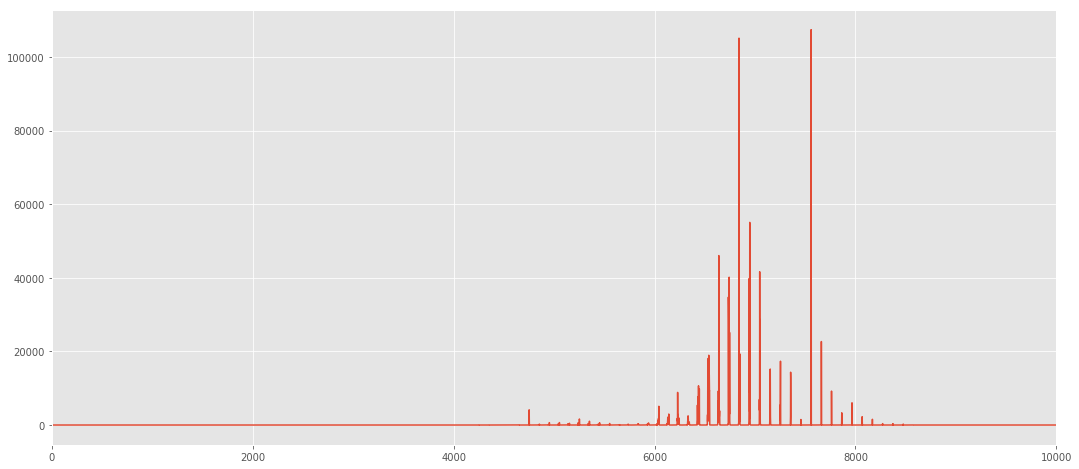

In [72]:
with fig():
    densities.var(axis=0).plot()

In [99]:
#densities = densities.loc[:, densities.var(axis=0) > 1]
densities

0              1     \
s_id      pic                                                                
11119671  angry_EmGumz_25_plus4.jpg            1.134490e-93   1.965890e-98   
          angry_EmKocevski_25.jpg              0.000000e+00   0.000000e+00   
          angry_EmSchufatinski_50.jpg          0.000000e+00   0.000000e+00   
          angry_EmValeance_25_plus3.jpg        0.000000e+00   0.000000e+00   
          angry_EwBliefert_50.jpg              0.000000e+00   0.000000e+00   
          angry_EwMicas_75.jpg                 0.000000e+00   0.000000e+00   
          angry_EwPerlick_50.jpg              7.302180e-265  1.002396e-266   
          angry_EwRothe_50.jpg                 8.882182e-83   1.843318e-82   
          anxious_EmBoehlefeld_50.jpg          0.000000e+00   0.000000e+00   
          anxious_EmKocevski_50.jpg            0.000000e+00   0.000000e+00   
          anxious_EmPatzke_25.jpg              0.000000e+00   0.000000e+00   
          anxious_EmSchufatinski_37.jpg        0.000000e+00   0.000000e+00   
          anxious_EwBliefert_50.jpg            0.000000e+00   0.000000e+00   
          anxious_EwKiss_75.jpg                0.000000e+00   0.000000e+00   
          anxious_EwMicas_50.jpg               0.000000e+00   0.000000e+00   
          anxious_EwOtt_75.jpg                1.932464e-306  1.248591e-307   
          disgust_EmFoerster_75.jpg            0.000000e+00   0.000000e+00   
          disgust_EmKocevski_75.jpg            0.000000e+00   0.000000e+00   
          disgust_EmLevent_37.jpg              0.000000e+00   0.000000e+00   
          disgust_EmWalter_50.jpg              0.000000e+00   0.000000e+00   
          disgust_EwBliefert_37.jpg            0.000000e+00   0.000000e+00   
          disgust_EwGospadar_75.jpg            0.000000e+00   0.000000e+00   
          disgust_EwHuebner_75.jpg             0.000000e+00   0.000000e+00   
          disgust_EwOtt_75.jpg                 0.000000e+00   0.000000e+00   
          joyful_EmFoerster_12.jpg             0.000000e+00   0.000000e+00   
          joyful_EmKocevski_12.jpg             0.000000e+00   0.000000e+00   
          joyful_EmLevent_25.jpg               0.000000e+00   0.000000e+00   
          joyful_EmRothkirch_37.jpg            0.000000e+00   0.000000e+00   
          joyful_EwBliefert_25.jpg             0.000000e+00   0.000000e+00   
          joyful_EwBraun_37.jpg                0.000000e+00   0.000000e+00   
...                                                     ...            ...   
833319872 disgust_EmLevent_37.jpg              0.000000e+00   0.000000e+00   
          disgust_EmWalter_50.jpg              0.000000e+00   0.000000e+00   
          disgust_EwBliefert_37.jpg            0.000000e+00   0.000000e+00   
          disgust_EwGospadar_75.jpg            0.000000e+00   0.000000e+00   
          disgust_EwHuebner_75.jpg             0.000000e+00   0.000000e+00   
          disgust_EwOtt_75.jpg                 0.000000e+00   0.000000e+00   
          joyful_EmFoerster_12.jpg             0.000000e+00   0.000000e+00   
          joyful_EmKocevski_12.jpg             0.000000e+00   0.000000e+00   
          joyful_EmLevent_25.jpg               0.000000e+00   0.000000e+00   
          joyful_EmRothkirch_37.jpg            0.000000e+00   0.000000e+00   
          joyful_EwBliefert_25.jpg             0.000000e+00   0.000000e+00   
          joyful_EwBraun_37.jpg                0.000000e+00   0.000000e+00   
          joyful_EwFriedrich_12.jpg            0.000000e+00   0.000000e+00   
          joyful_EwStudelny_12.jpg             0.000000e+00   0.000000e+00   
          sad_EmGumz_25.jpg                    0.000000e+00   0.000000e+00   
          sad_EmKocevski_25.jpg                0.000000e+00   0.000000e+00   
          sad_EmLexow_37.jpg                   0.000000e+00   0.000000e+00   
          sad_EmRothkirch_25.jpg               0.000000e+00   0.000000e+00   
          sad_EwBliefert_25_plus4.jpg          0.000000e+00   0.000000e+00   

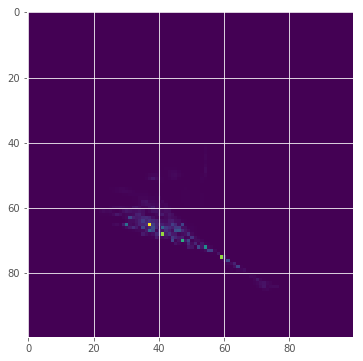

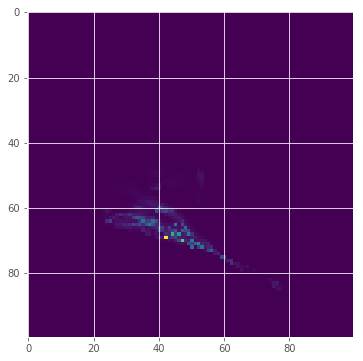

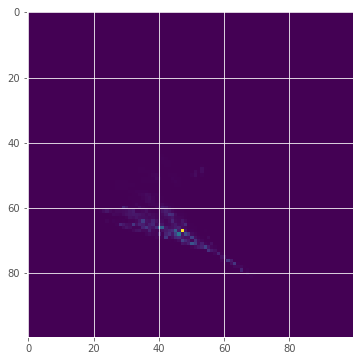

In [98]:
densities.index = densities.index.set_names(['s_id', 'pic'])

it = iter(densities.groupby('pic'))

with small_fig():
    pic, values = next(it)
    values = values.values.mean(axis=0)
    plt.imshow(values.reshape((100, 100)))

with small_fig():
    pic, values = next(it)
    values = values.values.mean(axis=0)
    plt.imshow(values.reshape((100, 100)))

with small_fig():
    pic, values = next(it)
    values = values.values.mean(axis=0)
    plt.imshow(values.reshape((100, 100)))


